# imports

In [1]:
import torch
import shutil # for filesystem manipulation

# NDN tools
import NDNT.utils as utils # some other utilities
from NTdatasets.cumming.monocular import MultiDataset
from NDNT.modules.layers import *
from NDNT.networks import *

import experiment as exp
import model as m

device = torch.device("cuda:1")
dtype = torch.float32

# load sample dataset to construct the model appropriately
datadir = './Mdata/'
num_lags = 10
expts = ['expt04']
dataset = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )

Invoking __init__.py for NDNT.utils
Loading expt04
  Time embedding...


# create model

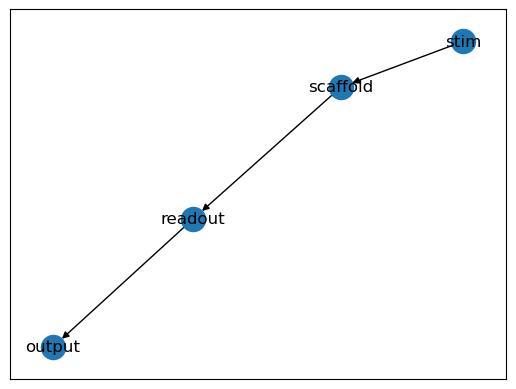

In [2]:
# create the Model
conv_layer0 = m.ConvolutionalLayer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'d2xt': 0.0001, 'center': None, 'bcs':{'d2xt':1} },
    num_filters=8,
    filter_dims=21,
    window='hamming',
    output_norm='batch',
    num_inh=4
)
conv_layer1 = m.ConvolutionalLayer().like(conv_layer0)
conv_layer1.params['num_filters'] = 8
conv_layer1.params['num_inh'] = 4
conv_layer1.params['filter_dims'] = 9
conv_layer2 = m.ConvolutionalLayer().like(conv_layer0)
conv_layer2.params['num_filters'] = 4
conv_layer2.params['num_inh'] = 2
conv_layer2.params['filter_dims'] = 9

readout_layer0 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.softplus,
    bias=True,
    reg_vals=[
        {'glocalx': 0.001}],
    pos_constraint=True
)

inp_stim = m.Input(covariate='stim', input_dims=dataset.stim_dims)

scaffold_net = m.Network(layers=[conv_layer0, conv_layer1, conv_layer2],
                         network_type=m.NetworkType.scaffold,
                         name='scaffold')
readout_net = m.Network(layers=[readout_layer0],
                        name='readout')
output_11 = m.Output(num_neurons=dataset.NC)

inp_stim.to(scaffold_net)
scaffold_net.to(readout_net)
readout_net.to(output_11)

model = m.Model(output_11)
model.draw_network()

# generate_trial

In [3]:
# for each data
# load sample dataset to construct the model appropriately
datadir = './Mdata/'
num_lags = 10
expts = [['expt04'], ['expt05']]

adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1, max_epochs=1)
adam_pars['device'] = device

def generate_trial(prev_trials):
    trial_idx = 0
    for expt in expts:
        print('prev_trials', len(prev_trials))
        
        print('Loading dataset for', expt)
        dataset_params = {
            'datadir': datadir, 
            'filenames': expt, 
            'include_MUs': False,
            'time_embed': True,
            'num_lags': num_lags
        }
        expt_dataset = MultiDataset(**dataset_params)
        
        eval_params = {
            'null_adjusted': True
        }
        
        # update model based on the provided params
        # modify the model_template.output to match the data.NC before creating
        print('Updating model output neurons to:', expt_dataset.NC)
        model.update_num_neurons(expt_dataset.NC)
        
        trial_info = exp.TrialInfo(name='test'+str(trial_idx),
                                   description='testdesc'+str(trial_idx),
                                   dataset_params=dataset_params,
                                   dataset_class=MultiDataset,
                                   fit_params=adam_pars,
                                   eval_params=eval_params)
        
        trial = exp.Trial(trial_info=trial_info,
                          model=model,
                          dataset=expt_dataset)
        trial_idx += 1
        
        yield trial

# run experiment

In [4]:
from importlib import reload
experiment = exp.Experiment(name='testexp',
                            description='testexpdesc',
                            generate_trial=generate_trial,
                            experiment_location='test_experiments',
                            overwrite=exp.Overwrite.overwrite)
experiment.run()

prev_trials 0
Loading dataset for ['expt04']
Loading expt04
  Time embedding...
Updating model output neurons to: 11

GPU Available: True, GPU Used: True
Epoch 1: train loss 1028.7593 val loss 1004.2520
Done fitting
  Fit complete: 14.52156400680542 sec elapsed
prev_trials 1
Loading dataset for ['expt05']
Loading expt05
  Time embedding...
Updating model output neurons to: 9

GPU Available: True, GPU Used: True
Epoch 1: train loss 1123.0527 val loss 1112.5046
Done fitting
  Fit complete: 7.008072137832642 sec elapsed


In [5]:
experiment.trials

[<experiment.Trial at 0x7f6a2c5e5850>, <experiment.Trial at 0x7f6a2c59c040>]

In [6]:
loaded = exp.load('testexp', 'test_experiment')

In [7]:
loaded.trials

[<experiment.Trial at 0x7f696d0b2ca0>, <experiment.Trial at 0x7f696d0c5f10>]

In [10]:
loaded['test0'].dataset

In [12]:
loaded['test1'].dataset

lazy loading dataset
Loading expt05
  Time embedding...
